In [35]:
# Standard Python Library

import os
import itertools

from collections import namedtuple

# Additional Modules

import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from skimage import data, img_as_float64, img_as_ubyte
from skimage.metrics import mean_squared_error as mse, peak_signal_noise_ratio as psnr
from skimage.transform import resize
from skimage.color import rgb2gray, rgb2yuv, yuv2rgb

from tqdm import tqdm

In [36]:
_depth_stride = {64 : 32, 32 : 16, 16 : 8, 8 : 4, 4 : 4}
_family_container = {}
_threshold_bits = 10
_scale_bits = 5
_bias_bits = 7

metadata = []
codebook = []
codebook_bak = []
_quad_split = []
_quad_split_bak = []

In [37]:
def _int_quantize(number, bits):
    return np.int(np.rint((2 ** bits - 1) * number))

def _float_quantize(number, bits):
    return _int_quantize(number, bits) / (2 ** bits - 1)

In [38]:
def _affine(image, rotate_flip):
    times, flip = rotate_flip % 4, rotate_flip // 4
    if flip == 1:
        image = np.flip(image, 1)
    return np.rot90(image, times)

In [39]:
def _get_id(block, block_size):
    block_size = block_size // 2
    sum1 = np.sum(block[: block_size, : block_size])
    sum2 = np.sum(block[: block_size, block_size : 2 * block_size])
    sum3 = np.sum(block[block_size : 2 * block_size, block_size : 2 * block_size])
    sum4 = np.sum(block[block_size : 2 * block_size, : block_size])
    l = [(sum1, 0), (sum2, 1), (sum3, 2), (sum4, 3)]
    block_id = "".join(str(x[1]) for x in sorted(l))
    if (len(block_id) != 4):
        assert False, "block_id len = {}, d : {}".format(len(block_id), l)
    return block_id

def _determine_family(resized_image, block_size):
    stride = _depth_stride[block_size]
    H, W = resized_image.shape
    xs = np.arange(0, H, stride)
    ys = np.arange(0, W, stride)
#     print(f"stride={stride},block_size={block_size},xs={xs}, ys={ys}")
    for x, y in itertools.product(xs, ys):
        for tf in range(8):
            domain_id = _get_id(_affine(resized_image[x : x + block_size, y : y + block_size], tf), block_size)
            # print(f"domain_id={domain_id}")
            _family_container.update({(x, y, block_size, tf) : domain_id})

In [40]:
def _quadtree_find_rank_transform(image, resized_image, x, y, block_size):
    stride = _depth_stride[block_size]
    
    rank_block = image[x : x + block_size, y : y + block_size] 
    rank_block_id = _get_id(rank_block, block_size)
    difference = np.inf
    best_transform = None

    H, W = resized_image.shape
    dims = block_size ** 2
#     print(f"x={x},y={y},stride={stride},H={H},W={W},block_size={block_size}")

    xs = np.arange(0, H, stride)
    ys = np.arange(0, W, stride)
    for x_domain in xs:
        for y_domain in ys:
            if x_domain + block_size > H or y_domain + block_size > W:
                continue

            match_any = False
            for tf in range(8):
                match_any |= rank_block_id == _family_container[(x_domain, y_domain, block_size, tf)] or \
                        rank_block_id == _family_container[(x_domain, y_domain, block_size, tf)][::-1]
            if not match_any:
                continue

            domain_block = resized_image[x_domain : x_domain + block_size, y_domain : y_domain + block_size]
            rank_sum = np.sum(rank_block)
            rank_squared = np.sum(rank_block * rank_block)

            domain_sum = np.sum(domain_block)
            domain_squared = np.sum(domain_block * domain_block)
            for flip in range(2):
                for times in range(4):
                    if rank_block_id != _family_container[(x_domain, y_domain, block_size, 4 * flip + times)] and \
                        rank_block_id != _family_container[(x_domain, y_domain, block_size, 4 * flip + times)][::-1]:
                        continue
                    domain_block = _affine(domain_block, 4 * flip + times)
                    element_wise = np.sum(domain_block * rank_block)

                    denominator = dims * domain_squared - domain_sum ** 2
                    if np.abs(denominator) > 1e-8: 
                        scale = (dims * element_wise - domain_sum * rank_sum) / denominator
                        scale = np.sign(scale) * min(1, np.abs(scale))
                        scale = _float_quantize(scale, _scale_bits)
                    else:
                        scale = 0
                    bias = (rank_sum - scale * domain_sum) / dims
                    bias = np.sign(bias) * min(1, np.abs(bias))
                    bias = _float_quantize(bias, _bias_bits)

                    curr_diff = np.sum((rank_block - (domain_block * scale + bias)) ** 2)
                    if curr_diff < difference:
                        difference = curr_diff
                        scale_is_negative = np.int(scale < 0)
                        bias_is_negative = np.int(bias < 0)

                        scale = _int_quantize(scale, _scale_bits)
                        bias = _int_quantize(bias, _bias_bits)

                        best_transform = (x_domain, y_domain, times + flip * 4, 
                                          (np.abs(scale), scale_is_negative, np.abs(bias), bias_is_negative))
    if best_transform is None:
        print("Transform wasn't found, block_size : {}".format(block_size))
        print(Counter(self._family_container.values()))
        print(len(Counter(self._family_container.values())))
        assert False
    return best_transform, difference

In [51]:
def _quadtree_find_tf(image, resized_image, x, y, block_size, threshold):
    transform, loss = _quadtree_find_rank_transform(image, resized_image, x, y, block_size)
    loss /= block_size ** 2
    loss = np.sqrt(loss)
#     print(transform)
    # print(f"x={x},y={y},transform={transform},loss={loss},block_size={block_size},threshold={threshold}, minblock={min_block_size_reached}")
    if loss > threshold and block_size > 4:
        block_size = block_size // 2
        # is recursive
        _quad_split.append(1)
        _quadtree_find_tf(image, resized_image, x, y, block_size, threshold)
        _quadtree_find_tf(image, resized_image, x, y + block_size, block_size, threshold)
        _quadtree_find_tf(image, resized_image, x + block_size, y  + block_size, block_size, threshold)
        _quadtree_find_tf(image, resized_image, x + block_size, y, block_size, threshold)
        return
    # no recursive
    _quad_split.append(0)
    codebook.append(transform)

In [42]:
def _quadtree_compress(image, block_size=32, threshold=63):
    H, W = image.shape
    xs = range(0, H, block_size)
    ys = range(0, W, block_size)
    
    source_image = img_as_float64(image)
    metadata.append([H, W, 0, block_size, threshold])
    
    threshold /= 2 ** _threshold_bits
    
    resized_image = resize(source_image, (H // 2, W // 2))
    for t_block_size in [32, 16, 8, 4]:
        _determine_family(resized_image, t_block_size)
    for x, y in tqdm(itertools.product(xs, ys), total = len(xs) * len(ys)):
        _quadtree_find_tf(source_image, resized_image, x, y, block_size, threshold)

In [43]:
def _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x, y):
    rank_block = image[x : x + block_size, y : y + block_size]
    
    if len(_quad_split) > 0:
        recursive_dig = _quad_split[0]
        _quad_split.pop(0)
    else:
        raise Exception("_quad_split is empty...")
    if recursive_dig and block_size  > 4:
        block_size = block_size // 2
        rank_block[: block_size, : block_size] = \
            _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x, y)

        rank_block[: block_size, block_size : 2 * block_size] = \
            _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x, y + block_size)

        rank_block[block_size : 2 * block_size, block_size : 2 * block_size] = \
            _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x + block_size, y + block_size)

        rank_block[block_size : 2 * block_size, : block_size] = \
            _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x + block_size, y)
        return rank_block
    
    if len(codebook) > 0:
        transform = codebook[0]
        codebook.pop(0)
    else:
        raise Exception("codebook is empty...")
    domain_x, domain_y, rotate_flip, (scale, scale_is_neg, bias, bias_is_neg) = transform
    scale /= 2 ** _scale_bits - 1
    bias  /= 2 ** _bias_bits  - 1
    if bias_is_neg:
        bias *= -1
    if scale_is_neg:
        scale *= -1
    rank_block = scale * _affine(resized_image[domain_x : domain_x + block_size, domain_y : domain_y + block_size], rotate_flip) + bias
    return rank_block

def _quadtree_apply_transforms(image, resized_image, codebook, _quad_split, block_size=32):
    N, M = image.shape
    xs = range(0, N, block_size)
    ys = range(0, M, block_size)
    for x, y in itertools.product(xs, ys):
        image[x : x + block_size, y : y + block_size] = \
            _quadtree_apply_one_transform(image, resized_image, codebook, _quad_split, block_size, x, y)
    return image

In [62]:
def _quadtree_decompress(byte_array, metadata_idx, num_iters=10):
    [height, width, colored, block_size, threshold] = metadata[metadata_idx]
    
    codebook = copy.deepcopy(codebook_bak)
    _quad_split = copy.deepcopy(_quad_split_bak)
    image = img_as_float64(np.ones((height, width)))
    for iteration in range(num_iters):
        resized_image = resize(image, (height // 2, width // 2))
        image = _quadtree_apply_transforms(image, resized_image, codebook, _quad_split, block_size=block_size)
        codebook = copy.deepcopy(codebook_bak)
        _quad_split = copy.deepcopy(_quad_split_bak)

    image = np.clip(image, -1, 1)
    return img_as_ubyte(image)

In [52]:
def _quadtree_compress_threshold(image, threshold_lvl):
    if threshold_lvl == 0:
        _quadtree_compress(image, block_size=32, threshold=1000)
    elif threshold_lvl == 20:
        _quadtree_compress(image, block_size=32, threshold=400)
    elif threshold_lvl == 40:
        _quadtree_compress(image, block_size=32, threshold=200)
    elif threshold_lvl == 60:
        _quadtree_compress(image, block_size=32, threshold=150)
    elif threshold_lvl == 80:
        _quadtree_compress(image, block_size=32, threshold=100)
    elif threshold_lvl == 100:
        _quadtree_compress(image, block_size=32, threshold=50)

In [117]:
import copy

n_iters = [1, 5, 10, 20]
compressed_images_bytes = []
decompressed_images = []
for lvl in threshold_lvl:
    # reset everything
    metadata.clear()
    codebook.clear()
    codebook_bak.clear()
    _quad_split.clear()
    _quad_split_bak.clear()

    threshold_lvl = [0, 20, 40, 60, 80, 100]

    lenna_rgb_512x512 = io.imread('data/lena.jpg')
    lenna_rgb_256x256 = resize(lenna_rgb_512x512, (256, 256))
    lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_256x256) * 255).astype('uint8')
    _quadtree_compress(image=lenna_gray_256x256, block_size=32, threshold=lvl)

    # get both baks
    codebook_bak = copy.deepcopy(codebook)
    _quad_split_bak = copy.deepcopy(_quad_split)
    
    print(len(codebook) + len(_quad_split))
    compressed_images_bytes.append(len(codebook) + len(_quad_split))
    
    imgs = [_quadtree_decompress(compressed_images[0],0, n) for n in n_iters]
    decompressed_images.append(imgs)
#     print(len(decompressed_images))




  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

  2%|█▎                                                                                 | 1/64 [00:06<06:42,  6.39s/it]

  3%|██▌                                                                                | 2/64 [00:11<06:21,  6.16s/it]

  5%|███▉                                                                               | 3/64 [00:17<06:01,  5.92s/it]

  6%|█████▏                                                                             | 4/64 [00:22<05:42,  5.71s/it]

  8%|██████▍                                                                            | 5/64 [00:27<05:28,  5.57s/it]

  9%|███████▊                                                                           | 6/64 [00:33<05:24,  5.59s/it]

 11%|█████████                                                                          | 7/64 [00:39<05:22,  5.67s/it]

 12%|██████████▍              

9536




  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

  2%|█▎                                                                                 | 1/64 [00:01<01:04,  1.03s/it]

  6%|█████▏                                                                             | 4/64 [00:02<00:50,  1.19it/s]

  8%|██████▍                                                                            | 5/64 [00:02<00:46,  1.26it/s]

  9%|███████▊                                                                           | 6/64 [00:03<00:42,  1.36it/s]

 11%|█████████                                                                          | 7/64 [00:06<01:20,  1.41s/it]

 12%|██████████▍                                                                        | 8/64 [00:08<01:22,  1.48s/it]

 14%|███████████▋                                                                       | 9/64 [00:10<01:30,  1.65s/it]

 16%|████████████▊            

5399




  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

  6%|█████▏                                                                             | 4/64 [00:00<00:05, 10.03it/s]

  8%|██████▍                                                                            | 5/64 [00:00<00:10,  5.68it/s]

 11%|█████████                                                                          | 7/64 [00:02<00:19,  2.99it/s]

 12%|██████████▍                                                                        | 8/64 [00:03<00:32,  1.74it/s]

 14%|███████████▋                                                                       | 9/64 [00:03<00:32,  1.72it/s]

 16%|████████████▊                                                                     | 10/64 [00:04<00:28,  1.93it/s]

 17%|██████████████                                                                    | 11/64 [00:05<00:32,  1.64it/s]

 19%|███████████████▍         

3439




  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

  8%|██████▍                                                                            | 5/64 [00:00<00:01, 43.31it/s]

 11%|█████████                                                                          | 7/64 [00:00<00:06,  9.48it/s]

 14%|███████████▋                                                                       | 9/64 [00:02<00:15,  3.56it/s]

 19%|███████████████▍                                                                  | 12/64 [00:02<00:11,  4.54it/s]

 20%|████████████████▋                                                                 | 13/64 [00:03<00:23,  2.15it/s]

 22%|█████████████████▉                                                                | 14/64 [00:04<00:36,  1.38it/s]

 23%|███████████████████▏                                                              | 15/64 [00:06<00:46,  1.04it/s]

 25%|████████████████████▌    

2235




  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

 11%|█████████                                                                          | 7/64 [00:00<00:03, 18.94it/s]

 12%|██████████▍                                                                        | 8/64 [00:00<00:12,  4.51it/s]

 20%|████████████████▋                                                                 | 13/64 [00:01<00:09,  5.28it/s]

 22%|█████████████████▉                                                                | 14/64 [00:03<00:30,  1.66it/s]

 23%|███████████████████▏                                                              | 15/64 [00:04<00:45,  1.09it/s]

 27%|█████████████████████▊                                                            | 17/64 [00:04<00:31,  1.49it/s]

 28%|███████████████████████                                                           | 18/64 [00:05<00:27,  1.69it/s]

 31%|█████████████████████████

1430




  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

 11%|█████████                                                                          | 7/64 [00:00<00:04, 11.44it/s]

 12%|██████████▍                                                                        | 8/64 [00:01<00:18,  2.98it/s]

 14%|███████████▋                                                                       | 9/64 [00:01<00:14,  3.71it/s]

 20%|████████████████▋                                                                 | 13/64 [00:01<00:10,  4.73it/s]

 22%|█████████████████▉                                                                | 14/64 [00:02<00:16,  3.12it/s]

 23%|███████████████████▏                                                              | 15/64 [00:03<00:20,  2.40it/s]

 28%|███████████████████████                                                           | 18/64 [00:03<00:15,  2.95it/s]

 33%|█████████████████████████

835


In [ ]:
import copy

n_iters = [1, 5, 10, 20]
compressed_images_bytes = []
decompressed_images = []
for lvl in threshold_lvl:
    # reset everything
    metadata.clear()
    codebook.clear()
    codebook_bak.clear()
    _quad_split.clear()
    _quad_split_bak.clear()

    threshold_lvl = [0, 20, 40, 60, 80, 100]

    lenna_rgb_512x512 = io.imread('data/lena.jpg')
#     lenna_rgb_256x256 = resize(lenna_rgb_512x512, (256, 256))
    lenna_gray_256x256 = np.rint(rgb2gray(lenna_rgb_512x512) * 255).astype('uint8')
    _quadtree_compress(image=lenna_gray_256x256, block_size=32, threshold=lvl)

    # get both baks
    codebook_bak = copy.deepcopy(codebook)
    _quad_split_bak = copy.deepcopy(_quad_split)
    
    print(len(codebook) + len(_quad_split))
    compressed_images_bytes.append(len(codebook) + len(_quad_split))
    
    imgs = [_quadtree_decompress(compressed_images[0],0, n) for n in n_iters]
    decompressed_images.append(imgs)
#     print(len(decompressed_images))




  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

  0%|▎                                                                               | 1/256 [00:21<1:30:41, 21.34s/it]

  1%|▋                                                                               | 2/256 [00:43<1:31:04, 21.51s/it]

  1%|▉                                                                               | 3/256 [01:03<1:29:24, 21.20s/it]

  2%|█▎                                                                              | 4/256 [01:24<1:28:02, 20.96s/it]

  2%|█▌                                                                              | 5/256 [01:44<1:26:47, 20.75s/it]

  2%|█▉                                                                              | 6/256 [02:03<1:24:54, 20.38s/it]

  3%|██▏                                                                             | 7/256 [02:24<1:24:58, 20.48s/it]

  3%|██▌                      

 52%|█████████████████████████████████████████▉                                      | 134/256 [46:22<42:45, 21.03s/it]

 53%|██████████████████████████████████████████▏                                     | 135/256 [46:43<42:05, 20.87s/it]

 53%|██████████████████████████████████████████▌                                     | 136/256 [47:04<42:16, 21.13s/it]

 54%|██████████████████████████████████████████▊                                     | 137/256 [47:28<43:11, 21.78s/it]

 54%|███████████████████████████████████████████▏                                    | 138/256 [47:50<43:13, 21.98s/it]

 54%|███████████████████████████████████████████▍                                    | 139/256 [48:14<44:06, 22.62s/it]

 55%|███████████████████████████████████████████▊                                    | 140/256 [48:36<43:18, 22.40s/it]

 55%|████████████████████████████████████████████                                    | 141/256 [48:58<42:32, 22.19s/it]

 55%|███████████████████████████

In [118]:
imgs = copy.deepcopy(decompressed_images)

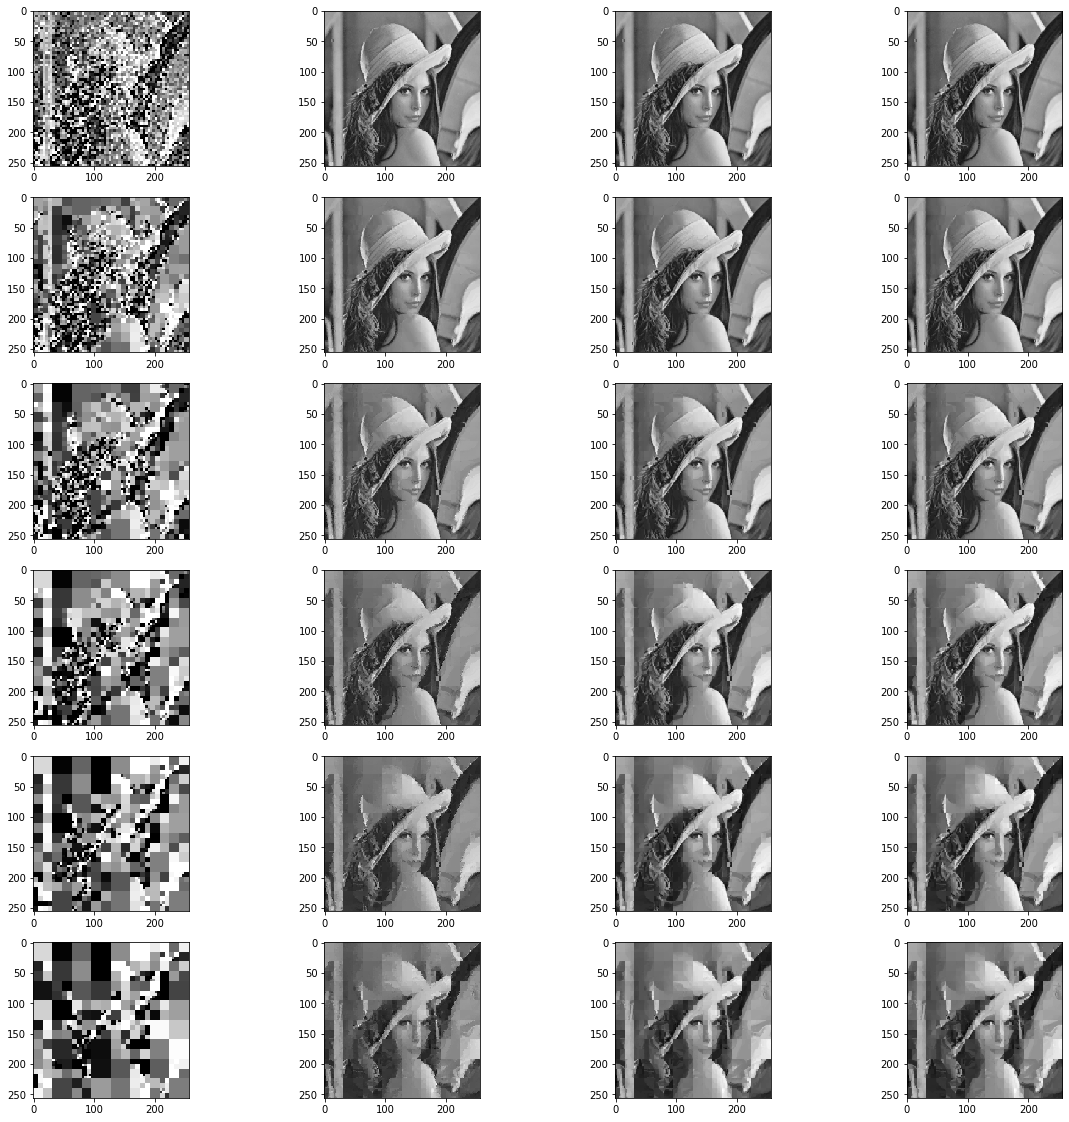

In [142]:
_, axs = plt.subplots(nrows=len(imgs),ncols=len(imgs[0]),figsize=(20, 20))
for row_idx in range(len(imgs)):
    for col_idx in range(len(imgs[row_idx])):
        axs[row_idx][col_idx].imshow(imgs[row_idx][col_idx], cmap='gray')
plt.show()

In [123]:
compression_rates = copy.deepcopy(compressed_images_bytes)

In [127]:
image = copy.deepcopy(lenna_gray_256x256)
psnrs = [psnr(image, decompressed[3]) for decompressed in decompressed_images]

In [133]:
original_image_size = 256*256

In [136]:
compression_ratio = []
for rate in compression_rates:
    compression_ratio.append(original_image_size / rate)

Text(0, 0.5, 'PSNR, dB')

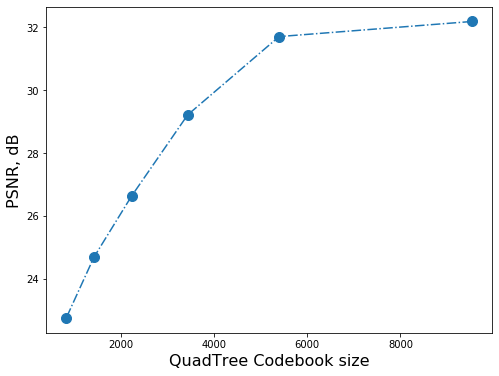

In [140]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(compression_rates, psnrs, marker='o', ms=10, ls='-.')
ax.set_xlabel('QuadTree Codebook size', fontsize=16)
ax.set_ylabel('PSNR, dB', fontsize=16)

Text(0, 0.5, 'PSNR, dB')

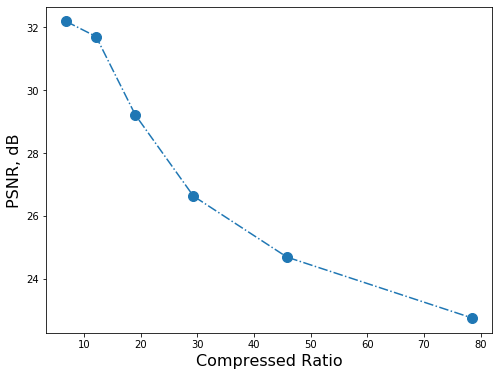

In [139]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(compression_ratio, psnrs, marker='o', ms=10, ls='-.')
ax.set_xlabel('Compressed Ratio', fontsize=16)
ax.set_ylabel('PSNR, dB', fontsize=16)